In [106]:
import pandas as pd
import requests
import gzip
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

Download the umitab.txt from GEO

In [3]:
# Download umitab file
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE54006&format=file&file=GSE54006%5Fumitab%2Etxt%2Egz"
response = requests.get(url)
with open("GSE54006_umitab.txt.gz", "wb") as file:
    file.write(response.content)

# Unzip the file
with gzip.open("GSE54006_umitab.txt.gz", "rb") as f_in:
    with open("GSE54006_umitab.txt", "wb") as f_out:
        f_out.write(f_in.read())


Load the experimental design txt

In [4]:
# load the experimental design, skipping the two comment lines
meta = pd.read_csv(
    "GSE54006_experimental_design.txt",
    sep="\t",
    skiprows=5,
    header=1,
)

meta.head(10)

index  sequencing_batch  ...  ERCC_volume_ul  Column_name_in_processed_data_file
0      1                 1  ...            0.01                                 0_1
1      2                 1  ...            0.01                                 0_2
2      3                 1  ...            0.01                                 0_3
3      4                 1  ...            0.01                                 0_4
4      5                 1  ...            0.01                                 0_5
5      6                 1  ...            0.01                                 0_6
6      7                 1  ...            0.01                                 0_7
7      8                 1  ...            0.01                                 0_8
8      9                 1  ...            0.01                                 0_9
9     10                 1  ...            0.01                                0_10

[10 rows x 15 columns]

Mapping the umitab with experiment design barcodes

In [5]:

# 3. Build a mapping:  UMI-tab column (e.g. “0_1”) → 6-mer barcode (e.g. “CTACCA”)
mapping = dict(zip(
    meta["Column_name_in_processed_data_file"],
    meta["sample_barcode"]
))

# 4. Load your UMI-tab (genes × “0_1”, “0_2”, …)
data = pd.read_csv(
    "GSE54006_umitab.txt",
    sep="\t",
    header=0,      # first line is: gene_name  0_1  0_2  …
    index_col=0    # first column is gene_name
)

# 5. Rename its columns in place to the 6-mer barcodes
data.rename(columns=mapping, inplace=True)

# # 6. Quick sanity-check
print(data.head())
data.shape


                    CTACCA  CATGCT  GCACAT  ...  CTGTGA  CATGCA  GATCGA
gene_name                                   ...                        
0610007C21Rik_Apr3       0       0       0  ...       0       0       1
0610007L01Rik            0       1       0  ...       0       0       0
0610007P08Rik            0       0       0  ...       0       0       0
0610007P14Rik            0       1       0  ...       0       0       0
0610007P22Rik            0       0       0  ...       0       0       0

[5 rows x 4590 columns]


(20190, 4590)

In [7]:
# expr is your genes×cells DataFrame (columns are 6-mers)
ercc_ids = [g for g in data.index if g.startswith("ERCC-")]
print(f"Found {len(ercc_ids)} ERCC spike‐in rows, examples:", ercc_ids[:5])

Found 83 ERCC spike‐in rows, examples: ['ERCC-00003', 'ERCC-00009', 'ERCC-00014', 'ERCC-00022', 'ERCC-00025']


In [8]:
data.to_csv("dataset.csv")

In [9]:
umi_df = pd.read_csv('dataset.csv', index_col='gene_name')

Load supplementary table 2 that contains ERCC concerations

In [81]:
# load sup2
sup2 = pd.read_csv(
    "NIHMS71488-supplement-Supplementary_Table_2.csv",
    sep=",",               
    encoding="latin-1",
    header=0,   
    index_col=0,
    engine="python"
)

# Keep only the MARS-Seq rows
sup2_mars = sup2[sup2.index.str.startswith('SRP035326')]

sup2_mars.head()

ERCC-00002  ERCC-00003  ...  accuracy  molecule_limit
SRP035326_batch_32_AACAAT        38.0         0.0  ...       inf             inf
SRP035326_batch_32_AACGCA        15.0         0.0  ...  0.925837     1731.820622
SRP035326_batch_32_AACTGG        10.0         0.0  ...       inf             inf
SRP035326_batch_32_AACTTG         3.0         0.0  ...  0.825265     1054.115502
SRP035326_batch_32_AAGACA        10.0         0.0  ...  0.876878     1118.648130

[5 rows x 101 columns]

Build only ERCC-concetrations dataset

In [16]:
# Load your dataframes

# STEP 1: Extract ERCC spike-ins from umitab
ercc_in_umitab = [name for name in data.index if name.startswith("ERCC-")]

# STEP 2: Extract ERCC spike-ins from sup2
ercc_in_sup2 = [col for col in sup2_mars.columns if col.startswith("ERCC-")]

# STEP 3: Find common ERCCs
common_erccs = list(set(ercc_in_umitab) & set(ercc_in_sup2))

# STEP 4: Subset sup2 to keep only these common ERCC columns
ercc_concentration_df = sup2_mars[common_erccs].copy()

# Optional: Print or inspect
print("Common ERCCs found:", common_erccs)
print(ercc_concentration_df.head())


Common ERCCs found: ['ERCC-00156', 'ERCC-00095', 'ERCC-00145', 'ERCC-00042', 'ERCC-00137', 'ERCC-00165', 'ERCC-00012', 'ERCC-00081', 'ERCC-00092', 'ERCC-00111', 'ERCC-00116', 'ERCC-00051', 'ERCC-00099', 'ERCC-00126', 'ERCC-00058', 'ERCC-00034', 'ERCC-00157', 'ERCC-00130', 'ERCC-00059', 'ERCC-00048', 'ERCC-00016', 'ERCC-00112', 'ERCC-00108', 'ERCC-00143', 'ERCC-00148', 'ERCC-00043', 'ERCC-00074', 'ERCC-00120', 'ERCC-00098', 'ERCC-00147', 'ERCC-00079', 'ERCC-00154', 'ERCC-00046', 'ERCC-00096', 'ERCC-00024', 'ERCC-00078', 'ERCC-00053', 'ERCC-00136', 'ERCC-00002', 'ERCC-00097', 'ERCC-00004', 'ERCC-00084', 'ERCC-00025', 'ERCC-00009', 'ERCC-00017', 'ERCC-00069', 'ERCC-00117', 'ERCC-00123', 'ERCC-00076', 'ERCC-00109', 'ERCC-00067', 'ERCC-00158', 'ERCC-00062', 'ERCC-00039', 'ERCC-00013', 'ERCC-00028', 'ERCC-00163', 'ERCC-00071', 'ERCC-00014', 'ERCC-00060', 'ERCC-00162', 'ERCC-00085', 'ERCC-00170', 'ERCC-00077', 'ERCC-00040', 'ERCC-00160', 'ERCC-00003', 'ERCC-00131', 'ERCC-00150', 'ERCC-00104',

In [83]:
# Extract barcode from sup2 index (assuming barcode is after the last underscore)
sup2_mars = sup2_mars.copy()
sup2_mars["Barcode"] = sup2_mars.index.str.split("_").str[-1]

# Now match common barcodes between umitab columns and sup2['barcode']
common_barcodes = list(set(data.columns) & set(sup2_mars['Barcode']))

# Filter umitab and sup2 to common barcodes
umitab_aligned = data[common_barcodes]
ercc_concentration_df =sup2_mars[sup2_mars['Barcode'].isin(common_barcodes)]

# Set barcode as index to match umitab
ercc_concentration_df = ercc_concentration_df.set_index('Barcode')
ercc_concentration_df = ercc_concentration_df.loc[common_barcodes, common_erccs]  # reorder and filter

ercc_concentration_df.shape
ercc_concentration_df.head()


ERCC-00156  ERCC-00095  ERCC-00145  ...  ERCC-00035  ERCC-00031  ERCC-00054
Barcode                                      ...                                    
GACCGT          0.0         0.0         0.0  ...         0.0         0.0         0.0
GACCGT          0.0         0.0         0.0  ...         1.0         0.0         0.0
GACCGT          0.0         0.0         0.0  ...         1.0         0.0         0.0
GACCGT          0.0         0.0         1.0  ...         1.0         1.0         0.0
GACCGT          0.0         0.0         0.0  ...         1.0         0.0         0.0

[5 rows x 83 columns]

Sequence depth downsampling

In [43]:
def downsample_counts(counts_df, target_depth):
    """
    Downsample each sample (column) in counts_df to the specified sequencing depth using multinomial sampling.
    Ensures shape matching and prints diagnostic info on error.
    """
    numeric_df = counts_df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
    downsampled = pd.DataFrame(index=numeric_df.index)

    for sample_name in numeric_df.columns:
        counts = numeric_df[sample_name]

        # Validate counts
        if counts.ndim != 1:
            print(f"[!] Skipping {sample_name} due to unexpected shape: {counts.shape}")
            continue

        counts_array = counts.values.flatten()  # ensure 1D
        total = counts_array.sum()

        if total == 0:
            downsampled[sample_name] = 0
            continue

        prob = counts_array / total
        prob = np.asarray(prob).flatten()  # final 1D safety

        if prob.shape[0] != len(numeric_df.index):
            print(f"[!] Mismatch before multinomial: prob length = {len(prob)}, expected = {len(numeric_df.index)}")
            continue

        try:
            new_counts = np.random.multinomial(target_depth, prob)
        except ValueError as e:
            print(f"[!] Multinomial error in sample '{sample_name}': {e}")
            new_counts = np.zeros_like(prob)

        # Final safety check before assignment
        if len(new_counts) != len(numeric_df.index):
            print(f"[!] Shape mismatch assigning {sample_name}: new_counts = {len(new_counts)}, index = {len(numeric_df.index)}")
            continue

        downsampled[sample_name] = new_counts  # direct array assignment, safe now

    return downsampled.astype(int)


In [94]:
umitab_aligned.columns = [f"{col}_{i}" for i, col in enumerate(umitab_aligned.columns)]

In [97]:
depths = [5_000,10_000, 15_000]
umitab_subsamples = {
    depth: downsample_counts(umitab_aligned, depth) for depth in depths
}

/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_44796/3062122086.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  downsampled[sample_name] = new_counts  # direct array assignment, safe now
/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_44796/3062122086.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  downsampled[sample_name] = new_counts  # direct array assignment, safe now
/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_44796/3062122086.py:42: PerformanceWarning: DataFrame is highly fra

In [98]:
umitab_subsamples.keys()

dict_keys([5000, 10000, 15000])

Metrics computation

In [99]:
def compute_all_detection_limits(umitab_subsamples, ercc_concentration_df, common_erccs):
    """
    For each downsampled depth, compute detection limits per sample and return a DataFrame.
    """

    def compute_detection_limit_per_sample(sample_counts, spikein_concs):
        y = (sample_counts > 0).astype(int).values
        x = np.log10(spikein_concs.values + 1).reshape(-1, 1)
        try:
            model = LogisticRegression(solver='liblinear')
            model.fit(x, y)
            x_50 = -model.intercept_[0] / model.coef_[0][0]
            return 10 ** x_50
        except:
            return np.nan

    all_limits = {}

    for depth, downsampled_df in umitab_subsamples.items():
        limits = {}
        for sample in downsampled_df.columns:
            ercc_counts = downsampled_df[sample].loc[common_erccs]
            barcode = sample.split("_")[0]
            match = ercc_concentration_df[ercc_concentration_df.index.str.endswith(barcode)]

            if match.empty:
                print(f"Skipping {sample}: no match for barcode {barcode}")
                continue

            ercc_concs = match.iloc[0][common_erccs]
            limit = compute_detection_limit_per_sample(ercc_counts, ercc_concs)
            limits[sample] = limit

        all_limits[depth] = limits

    # Convert to DataFrame: rows = samples, columns = depths
    detection_df = pd.DataFrame(all_limits)
    detection_df.index.name = "Sample"
    return detection_df


In [102]:
umitab_subsamples_with_full = {
    'full': umitab_aligned,           # your original counts
    5_000:  umitab_subsamples[5_000],
    10_000: umitab_subsamples[10_000],
    15_000: umitab_subsamples[15_000],
}

detection_limits_df = compute_all_detection_limits(
    umitab_subsamples_with_full,
    ercc_concentration_df,
    common_erccs
)
print(detection_limits_df.head(-5))



                 full      5000     10000     15000
Sample                                             
GACCGT_0     7.179212  7.179212  7.179212  7.179212
GACCGT_1     3.886053  4.596458  4.349356  3.886053
GACCGT_2     5.708360  5.708360  5.708360  5.708360
GACCGT_3     3.984036  3.984036  3.984036  3.984036
GACCGT_4     4.928009  4.928009  4.928009  4.928009
...               ...       ...       ...       ...
TAGCTA_4580  7.151586  7.151586  7.151586  7.151586
TAGCTA_4581  8.758147  8.758147  8.758147  8.758147
TAGCTA_4582  9.771031  9.771031  9.771031  9.771031
TAGCTA_4583  5.598798  5.598798  5.598798  5.598798
TAGCTA_4584  5.050408  5.050408  5.050408  5.050408

[4585 rows x 4 columns]


In [103]:
def compute_all_accuracies(umitab_subsamples, ercc_concentration_df, common_erccs):
    """
    For each sequencing depth (including 'full'), compute per-sample Pearson R 
    between log10(ERCC concentration+1) and log10(ERCC count+1).
    Returns a DataFrame: rows = samples, columns = depths.
    """
    all_acc = {}

    for depth, df in umitab_subsamples.items():
        accs = {}
        for sample in df.columns:
            # 1) get counts & concentrations
            counts = df[sample].loc[common_erccs].astype(int)
            barcode = sample.split("_")[0]
            match = ercc_concentration_df[ercc_concentration_df.index.str.endswith(barcode)]
            if match.empty:
                continue
            concs = match.iloc[0][common_erccs].astype(float)

            # 2) only if at least 8 ERCCs detected
            if (counts > 0).sum() < 8:
                accs[sample] = np.nan
            else:
                x = np.log10(concs + 1)
                y = np.log10(counts + 1)
                r, _ = pearsonr(x, y)
                accs[sample] = r

        all_acc[depth] = accs

    # assemble into DataFrame
    accuracy_df = pd.DataFrame(all_acc)
    accuracy_df.index.name = "Sample"
    return accuracy_df


In [104]:
accuracy_df = compute_all_accuracies(
    umitab_subsamples_with_full,
    ercc_concentration_df,
    common_erccs
)
print(accuracy_df.head(-5))

                 full      5000     10000     15000
Sample                                             
GACCGT_0     0.910240  0.853522  0.846247  0.833990
GACCGT_1     0.849781  0.833076  0.817921  0.782930
GACCGT_2     0.824148  0.772437  0.772323  0.747576
GACCGT_3     0.842807  0.776683  0.754224  0.734510
GACCGT_4     0.896469  0.843342  0.803888  0.789055
...               ...       ...       ...       ...
TAGCTA_4580  0.938145  0.909951  0.877256  0.855111
TAGCTA_4581  0.933593  0.864615  0.839873  0.826734
TAGCTA_4582  0.951987  0.931999  0.914663  0.895113
TAGCTA_4583  0.915204  0.853047  0.851534  0.848325
TAGCTA_4584  0.937972  0.893771  0.870860  0.849421

[4585 rows x 4 columns]


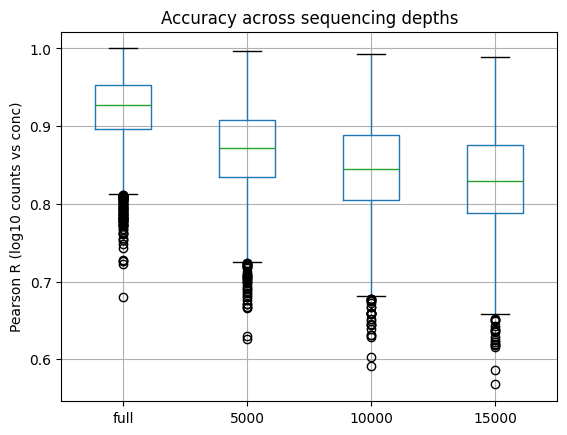

In [107]:
accuracy_df.boxplot()
plt.ylabel("Pearson R (log10 counts vs conc)")
plt.title("Accuracy across sequencing depths")
plt.show()
